
数据完整性验证：
X1样本数: 20891, 特征数: 8, 特征名称数: 8
X2样本数: 20891, 特征数: 69, 特征名称数: 69
正类比例: 51.52%

Training Model 1...


Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)


Epoch 1/40
Train Loss: 0.5222
Val AUC: 0.8336 | F1: 0.8190 | Accuracy: 0.8019 | Precision: 0.7736
Saved new best model with AUC: 0.8336
Epoch 2/40
Train Loss: 0.5166
Val AUC: 0.8103 | F1: 0.7796 | Accuracy: 0.7720 | Precision: 0.7765
Epoch 3/40
Train Loss: 0.5233
Val AUC: 0.8305 | F1: 0.8192 | Accuracy: 0.8055 | Precision: 0.7858
Epoch 4/40
Train Loss: 0.4946
Val AUC: 0.8461 | F1: 0.8087 | Accuracy: 0.7940 | Precision: 0.7751
Saved new best model with AUC: 0.8461
Epoch 5/40
Train Loss: 0.5090
Val AUC: 0.8395 | F1: 0.8131 | Accuracy: 0.7928 | Precision: 0.7594
Epoch 6/40
Train Loss: 0.4714
Val AUC: 0.8642 | F1: 0.8470 | Accuracy: 0.8421 | Precision: 0.8454
Saved new best model with AUC: 0.8642
Epoch 7/40
Train Loss: 0.4713
Val AUC: 0.8466 | F1: 0.8105 | Accuracy: 0.7918 | Precision: 0.7632
Epoch 8/40
Train Loss: 0.5423
Val AUC: 0.7591 | F1: 0.7780 | Accuracy: 0.7507 | Precision: 0.7186
Epoch 9/40
Train Loss: 0.5558
Val AUC: 0.7965 | F1: 0.7780 | Accuracy: 0.7310 | Precision: 0.6767
Epoc

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.04it/s]


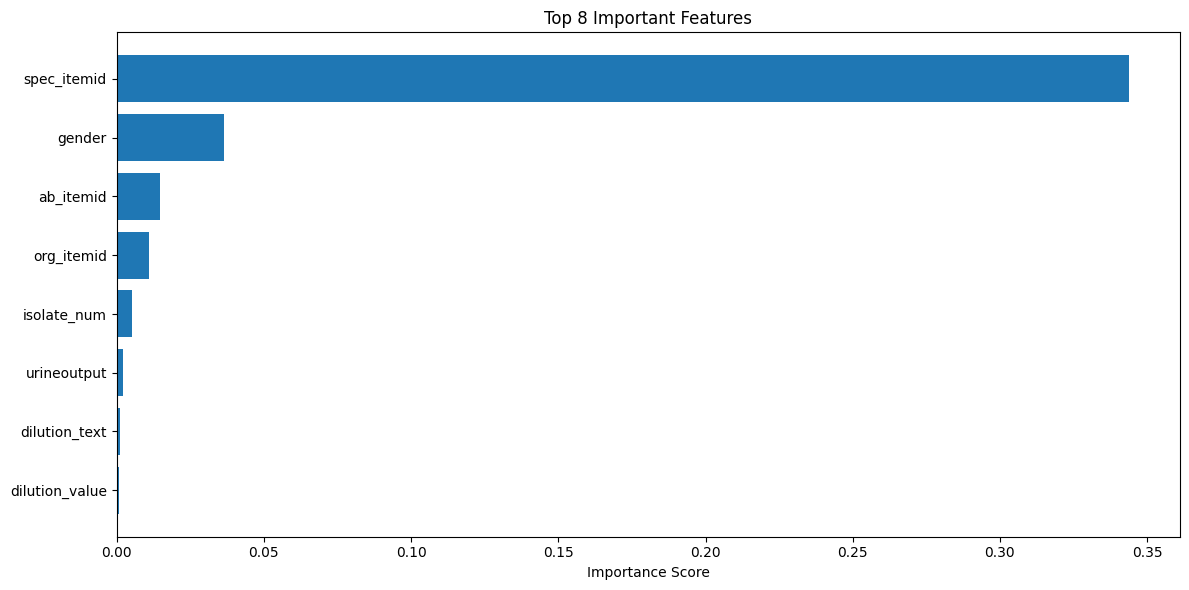


Feature Importance for Model 2:


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 69/69 [01:05<00:00,  1.06it/s]


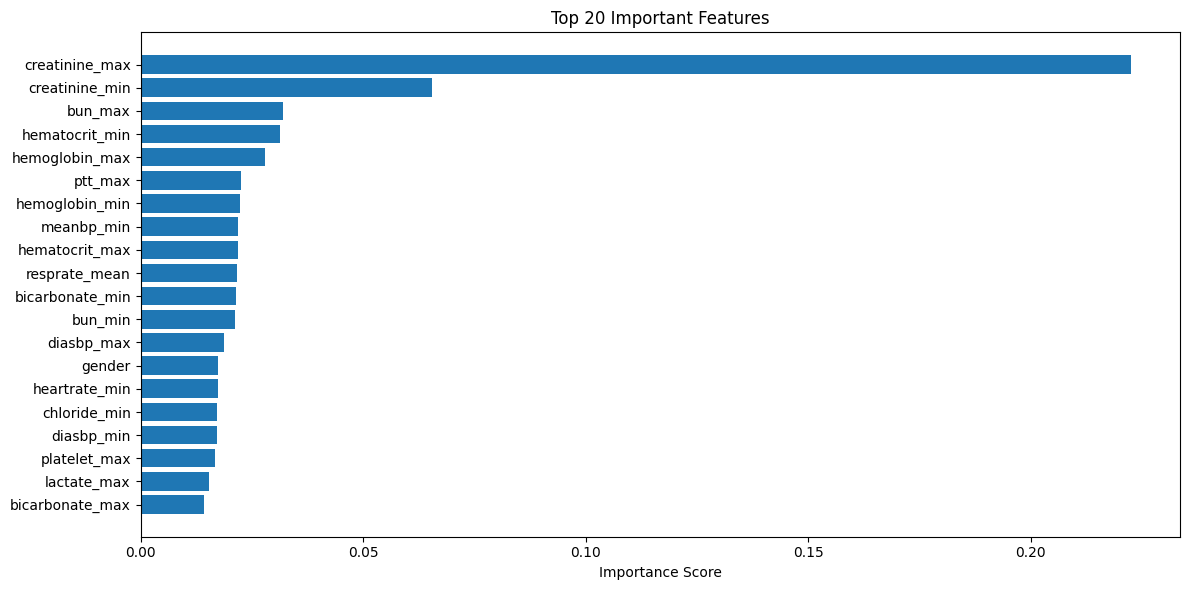


最终验证集类别分布 - 负类: 10129, 正类: 10762

Final Ensemble Performance:
AUC: 0.9493
Accuracy: 0.8799
Precision: 0.8762
Recall: 0.8930
F1: 0.8845


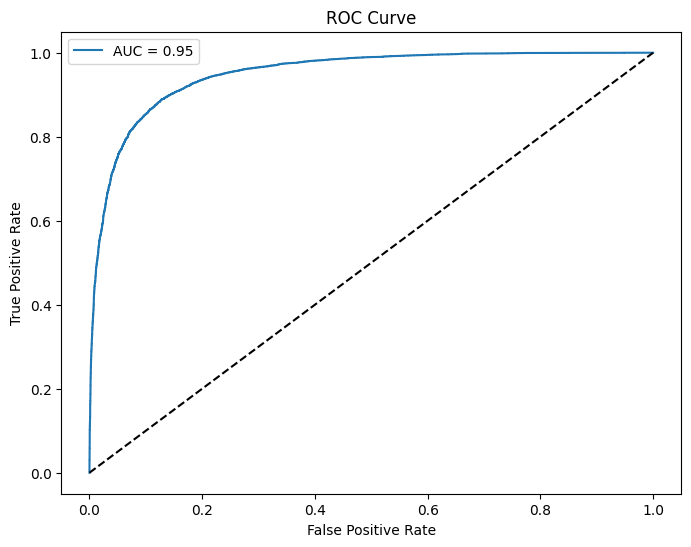

In [1]:
import random
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (accuracy_score, precision_score,
                             recall_score, f1_score, roc_auc_score,
                             roc_curve)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import (DataLoader, TensorDataset,
                              WeightedRandomSampler)
import matplotlib.pyplot as plt
from torchvision.transforms import Compose
from tqdm import tqdm

# 固定随机种子
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# --------------------------
# 时间序列增强模块
# --------------------------
class TemporalAugmentation:
    """时间序列数据增强"""
    def __init__(self, sigma=0.1, p=0.5):
        self.sigma = sigma  # 噪声强度
        self.p = p  # 应用概率

    def __call__(self, x):
        if np.random.rand() < self.p:
            noise = torch.randn_like(x) * self.sigma
            return x + noise
        return x

# --------------------------
# 深度残差块（带瓶颈结构）
# --------------------------
class BottleneckResidualBlock(nn.Module):
    """带瓶颈结构的深度残差块"""
    expansion = 4  # 通道扩展系数
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)
        
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, 
                              stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)
        
        self.conv3 = nn.Conv1d(out_channels, out_channels * self.expansion, 
                              kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm1d(out_channels * self.expansion)
        
        self.relu = nn.ReLU(inplace=True)
        
        # 跳跃连接
        self.downsample = nn.Sequential()
        if stride != 1 or in_channels != out_channels * self.expansion:
            self.downsample = nn.Sequential(
                nn.Conv1d(in_channels, out_channels * self.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(out_channels * self.expansion)
            )

        # self.drop_path = DropPath(drop_prob) if drop_prob > 0. else nn.Identity()
        # 通道注意力（改进版SE模块）
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),
            nn.Conv1d(out_channels * self.expansion, out_channels * self.expansion // 16, 1),
            nn.ReLU(),
            nn.Conv1d(out_channels * self.expansion // 16, out_channels * self.expansion, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        identity = self.downsample(x)
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        
        out = self.conv3(out)
        out = self.bn3(out)
        
        # 通道注意力应用
        se_weight = self.se(out)
        out = out * se_weight
        
        out += identity
        out = self.relu(out)
        return out
# --------------------------
# 深度残差网络架构
# --------------------------
class DeepResNet(nn.Module):
    def __init__(self, input_dim, block=BottleneckResidualBlock, layers=[3, 4, 23, 3], lstm_hidden_size=256):
        super().__init__()
        self.in_channels = 64

        self.conv1 = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        )

        self.stage1 = self._make_stage(block, 64, layers[0], stride=1)
        self.stage2 = self._make_stage(block, 128, layers[1], stride=2)
        self.stage3 = self._make_stage(block, 256, layers[2], stride=2)
        self.stage4 = self._make_stage(block, 512, layers[3], stride=2)

        # BiLSTM 层
        self.lstm = nn.LSTM(input_size=512 * block.expansion, hidden_size=lstm_hidden_size, 
                            num_layers=2, bidirectional=True, batch_first=True)

        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(lstm_hidden_size * 2, 1)
        )

                # 参数初始化
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    def _make_stage(self, block, out_channels, blocks, stride=1):
        """构建网络阶段"""
        layers = []
        # 第一个块处理下采样
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels * block.expansion
        # 后续块保持通道数不变
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))
        
        return nn.Sequential(*layers)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.conv1(x)

        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)

        x = x.permute(0, 2, 1)  # [batch, seq_len, channels]
        x, _ = self.lstm(x)
        x = x[:, -1, :]  # 取最后一个时间步的输出
        x = self.fc(x)
        return x.squeeze(1)

# --------------------------
# 注意力融合模块
# --------------------------
class AttentionFusion(nn.Module):
    """基于注意力的模型融合"""
    def __init__(self, modelA, modelB):
        super().__init__()
        self.modelA = modelA
        self.modelB = modelB
        self.attention = nn.Sequential(
            nn.Linear(2, 8),
            nn.Tanh(),
            nn.Linear(8, 2),
            nn.Softmax(dim=1)
        )

    def forward(self, x1, x2):
        with torch.no_grad():
            logitA = self.modelA(x1)
            logitB = self.modelB(x2)
        concat_logits = torch.stack([logitA, logitB], dim=1)
        weights = self.attention(concat_logits)
        probA = torch.sigmoid(logitA)
        probB = torch.sigmoid(logitB)
        return (weights[:, 0] * probA) + (weights[:, 1] * probB)

# --------------------------
# 模型解释模块
# --------------------------
def feature_importance(model, X, feature_names, n_samples=1000):
    model.eval()
    baseline = torch.mean(X, dim=0, keepdim=True)
    delta_list = []
    
    # 确保特征数量与特征名称数量一致
    if X.shape[1] != len(feature_names):
        print(f"警告：特征数量 ({X.shape[1]}) 与特征名称数量 ({len(feature_names)}) 不匹配")
        print("可能原因：数据预处理时某些列未被正确移除或加载")
        return
    
    with torch.no_grad():
        for i in tqdm(range(X.shape[1])):
            perturbed = X.clone()
            perturbed[:, i] = baseline[0, i]
            orig_output = torch.sigmoid(model(X))
            perturbed_output = torch.sigmoid(model(perturbed))
            delta = torch.mean(torch.abs(orig_output - perturbed_output)).item()
            delta_list.append(delta)

    # 动态确定显示数量
    display_num = min(20, len(delta_list))  # 取特征数量和前20中的较小值
    indices = np.argsort(delta_list)[::-1][:display_num]  # 只取实际存在的索引
    
    plt.figure(figsize=(12, 6))
    plt.barh(range(display_num), [delta_list[i] for i in indices][::-1])
    plt.yticks(range(display_num), [feature_names[i] for i in indices][::-1])
    plt.xlabel('Importance Score')
    plt.title(f'Top {display_num} Important Features')
    plt.tight_layout()
    plt.show()

# --------------------------
# 训练评估模块（优化版）
# --------------------------
def train_and_evaluate(model, train_loader, val_loader, optimizer, criterion,
                       scheduler=None, epochs=30, save_path='best_model.pth'):
    history = {'train_loss': [], 'val_auc': [], 'val_f1': [],
               'val_accuracy': [], 'val_precision': []}
    best_auc = 0
    early_stop = EarlyStopper(patience=10)

    for epoch in range(epochs):
        # 训练阶段
        model.train()
        train_loss = 0
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = model(X)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        history['train_loss'].append(train_loss)

        # 验证阶段
        model.eval()
        y_true, y_probs = [], []
        with torch.no_grad():
            for X, y in val_loader:
                X = X.to(device)
                outputs = model(X)
                y_true.extend(y.cpu().numpy())
                y_probs.extend(torch.sigmoid(outputs).cpu().numpy())

        # 计算指标
        auc = roc_auc_score(y_true, y_probs)
        preds = np.round(y_probs)
        f1 = f1_score(y_true, preds)
        accuracy = accuracy_score(y_true, preds)
        precision = precision_score(y_true, preds)

        history['val_auc'].append(auc)
        history['val_f1'].append(f1)
        history['val_accuracy'].append(accuracy)
        history['val_precision'].append(precision)

        # 学习率调度
        if scheduler:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(auc)
            else:
                scheduler.step()

        print(f"Epoch {epoch + 1}/{epochs}")
        print(f"Train Loss: {train_loss:.4f}")
        print(f"Val AUC: {auc:.4f} | F1: {f1:.4f} | Accuracy: {accuracy:.4f} | Precision: {precision:.4f}")

        # 保存最佳模型
        if auc > best_auc:
            best_auc = auc
            torch.save(model.state_dict(), save_path)
            print(f"Saved new best model with AUC: {auc:.4f}")

        if early_stop(auc):
            print("Early stopping triggered!")
            break

    model.load_state_dict(torch.load(save_path))
    return model, history

# --------------------------
# 主流程
# --------------------------
def main():
    # 加载数据
    df1 = pd.read_csv('./data/cleaned_microbiologyevents_plus.csv')
    df2 = pd.read_csv('./data/cleaned_labs_first_day_plus_vitals_first_day_raw.csv')
    target = 'match_flag'

    # 数据对齐
    common_ids = np.intersect1d(df1['hadm_id'], df2['hadm_id'])  # 假设存在唯一标识列
    df1 = df1[df1['hadm_id'].isin(common_ids)].sort_values('hadm_id').reset_index(drop=True)
    df2 = df2[df2['hadm_id'].isin(common_ids)].sort_values('hadm_id').reset_index(drop=True)

    # 特征工程
    feature_names1 = df1.drop(columns=[target, 'hadm_id']).columns.tolist()  # 提取特征名称
    feature_names2 = df2.drop(columns=[target, 'hadm_id']).columns.tolist()
    X1 = df1.drop(columns=[target, 'hadm_id']).values.astype(np.float32)  # 移除标识列和目标列
    X2 = df2.drop(columns=[target, 'hadm_id']).values.astype(np.float32)
    y = df1[target].values.astype(np.float32)

    # 添加数据完整性检查
    print("\n数据完整性验证：")
    print(f"X1样本数: {len(X1)}, 特征数: {X1.shape[1]}, 特征名称数: {len(feature_names1)}")
    print(f"X2样本数: {len(X2)}, 特征数: {X2.shape[1]}, 特征名称数: {len(feature_names2)}")
    print(f"正类比例: {np.mean(y):.2%}")
    assert len(X1) == len(X2) == len(y), "特征与标签数量不匹配"
    assert X1.shape[1] == len(feature_names1), "X1 特征数量与特征名称不匹配"
    assert X2.shape[1] == len(feature_names2), "X2 特征数量与特征名称不匹配"

    # 训练模型1
    print("\nTraining Model 1...")
    dataset1 = TensorDataset(torch.FloatTensor(X1), torch.FloatTensor(y))
    train_loader1, val_loader1 = create_loaders(dataset1)
    model1 = DeepResNet(X1.shape[1]).to(device)
    optimizer1 = optim.AdamW(model1.parameters(), lr=0.001, weight_decay=1e-4)
    criterion1 = nn.BCEWithLogitsLoss(pos_weight=calc_pos_weight(y))
    scheduler1 = optim.lr_scheduler.ReduceLROnPlateau(optimizer1, mode='max', factor=0.1, patience=3)
    model1, hist1 = train_and_evaluate(model1, train_loader1, val_loader1, optimizer1,
                                     criterion1, scheduler=scheduler1, epochs=40,save_path='best_model1.pth')

    # 训练模型2
    print("\nTraining Model 2...")
    dataset2 = TensorDataset(torch.FloatTensor(X2), torch.FloatTensor(y))
    train_loader2, val_loader2 = create_loaders(dataset2)
    model2 = DeepResNet(X2.shape[1]).to(device)
    optimizer2 = optim.AdamW(model2.parameters(), lr=0.001, weight_decay=1e-4)
    criterion2 = nn.BCEWithLogitsLoss(pos_weight=calc_pos_weight(y))
    scheduler2 = optim.lr_scheduler.ReduceLROnPlateau(optimizer2, mode='max', factor=0.1, patience=3)
    model2, hist2 = train_and_evaluate(model2, train_loader2, val_loader2, optimizer2,
                                     criterion2, scheduler=scheduler2, save_path='best_model2.pth')

    # 加载最佳模型
    model1.load_state_dict(torch.load('best_model1.pth'))
    model2.load_state_dict(torch.load('best_model2.pth'))

        # 在模型训练后添加
    background_samples = 300  # 控制计算时间
    
    # # 对模型1的分析
    # shap_feature_analysis(
    #     model1,
    #     torch.FloatTensor(X1[:background_samples]),
    #     torch.FloatTensor(X1[:5]),  # 解释前100个样本
    #     feature_names1,
    #     model_name="Microbiology_Model"
    # )
    
    # # 对模型2的分析 
    # shap_feature_analysis(
    #     model2,
    #     torch.FloatTensor(X2[:background_samples]),
    #     torch.FloatTensor(X2[:10]),
    #     feature_names2,
    #     model_name="Lab_Model"
    # )


    # 训练融合模型
    print("\nTraining Fusion Model...")
    fusion_model = AttentionFusion(model1, model2).to(device)
    optimizer = optim.AdamW(fusion_model.parameters(), lr=0.001)
    scheduler_fusion = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
    dataset = TensorDataset(torch.FloatTensor(X1), torch.FloatTensor(X2), torch.FloatTensor(y))
    train_loader = DataLoader(dataset, batch_size=128, shuffle=True)
    epoches = 20
    for epoch in range(epoches):
        total_loss = 0
        fusion_model.train()
        for X1_batch, X2_batch, y_batch in train_loader:
            X1_batch, X2_batch = X1_batch.to(device), X2_batch.to(device)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()
            probs = fusion_model(X1_batch, X2_batch)
            loss = nn.BCELoss()(probs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        scheduler_fusion.step()
        print(f"Epoch {epoch + 1}: Loss={total_loss / len(train_loader):.4f}, LR={optimizer.param_groups[0]['lr']:.6f}")
    
    # 模型解释与评估
    print("\nFeature Importance for Model 1:")
    feature_importance(model1, torch.FloatTensor(X1[:1000]).to(device), feature_names1)
    print("\nFeature Importance for Model 2:")
    feature_importance(model2, torch.FloatTensor(X2[:1000]).to(device), feature_names2)
    evaluate_ensemble(fusion_model, X1, X2, y)
    fusion_model.save(fusion_model,'fusion_model.onnx')
# --------------------------
# 辅助函数
# --------------------------

class EarlyStopper:
    def __init__(self, patience=10, min_delta=0.005):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None

    def __call__(self, score):
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        else:
            self.best_score = score
            self.counter = 0
        return False

def create_loaders(dataset, val_ratio=0.2):
    # 使用分层划分
    y = dataset.tensors[1].numpy()
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    train_idx, val_idx = next(skf.split(np.zeros(len(y)), y))
    
    train_dataset = torch.utils.data.Subset(dataset, train_idx)
    val_dataset = torch.utils.data.Subset(dataset, val_idx)
    
    # 类别平衡采样
    y_train = y[train_idx]
    sampler = WeightedRandomSampler(
        weights=calc_sample_weights(y_train),
        num_samples=len(train_dataset),
        replacement=True
    )
    
    train_loader = DataLoader(train_dataset, batch_size=64, sampler=sampler)
    val_loader = DataLoader(val_dataset, batch_size=64)
    return train_loader, val_loader

def calc_pos_weight(y):
    pos = np.sum(y)
    neg = len(y) - pos
    return torch.tensor([neg / pos]).to(device) if pos > 0 else torch.tensor([1.0]).to(device)

def calc_sample_weights(y):
    class_counts = np.bincount(y.astype(int))
    class_weights = 1. / class_counts
    return torch.tensor([class_weights[int(label)] for label in y])

def evaluate_ensemble(model, X1, X2, y):
    # 创建数据集时确保顺序一致
    dataset = TensorDataset(torch.FloatTensor(X1), torch.FloatTensor(X2), torch.FloatTensor(y))
    loader = DataLoader(dataset, batch_size=256, shuffle=False)  # 必须关闭shuffle
    
    model.eval()
    probs, truths = [], []
    with torch.no_grad():
        for X1_batch, X2_batch, y_batch in loader:
            X1_batch, X2_batch = X1_batch.to(device), X2_batch.to(device)
            batch_probs = model(X1_batch, X2_batch).cpu().numpy()
            probs.extend(batch_probs)
            truths.extend(y_batch.cpu().numpy())  # 直接使用loader提供的标签
    
    # 转换为numpy数组并验证
    truths = np.array(truths)
    probs = np.array(probs)
    print(f"\n最终验证集类别分布 - 负类: {np.sum(truths==0)}, 正类: {np.sum(truths==1)}")
    
    # 检查类别分布
    unique_classes = np.unique(truths)
    if len(unique_classes) == 1:
        print("\n警告：验证集只包含单一类别，无法计算AUC")
        class_dist = {0: np.sum(truths==0), 1: np.sum(truths==1)}
        print(f"类别分布: {class_dist}")
        return
    
    # 计算评估指标
    preds = np.round(probs)
    print("\nFinal Ensemble Performance:")
    try:
        auc = roc_auc_score(truths, probs)
        print(f"AUC: {auc:.4f}")
    except ValueError as e:
        print(f"AUC计算失败: {str(e)}")
        auc = 0
    
    print(f"Accuracy: {accuracy_score(truths, preds):.4f}")
    print(f"Precision: {precision_score(truths, preds):.4f}")
    print(f"Recall: {recall_score(truths, preds):.4f}")
    print(f"F1: {f1_score(truths, preds):.4f}")

    # 绘制ROC曲线
    if auc > 0:
        fpr, tpr, _ = roc_curve(truths, probs)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend()
        plt.show()

if __name__ == "__main__":
    main()

In [ ]:
import random
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (accuracy_score, precision_score,
                             recall_score, f1_score, roc_auc_score,
                             roc_curve)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import (DataLoader, TensorDataset,
                              WeightedRandomSampler,Subset)
import matplotlib.pyplot as plt
from tqdm import tqdm
from catboost import CatBoostClassifier

# 固定随机种子
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# --------------------------
# 深度残差网络架构
# --------------------------
class BottleneckResidualBlock(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3,
                              stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.conv3 = nn.Conv1d(out_channels, out_channels * self.expansion,
                              kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm1d(out_channels * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = nn.Sequential()
        if stride != 1 or in_channels != out_channels * self.expansion:
            self.downsample = nn.Sequential(
                nn.Conv1d(in_channels, out_channels * self.expansion,
                         kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(out_channels * self.expansion)
            )
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),
            nn.Conv1d(out_channels * self.expansion, out_channels * self.expansion // 16, 1),
            nn.ReLU(),
            nn.Conv1d(out_channels * self.expansion // 16, out_channels * self.expansion, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        identity = self.downsample(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv3(out)
        out = self.bn3(out)
        se_weight = self.se(out)
        out = out * se_weight
        out += identity
        out = self.relu(out)
        return out

class DeepResNet(nn.Module):
    def __init__(self, input_dim, block=BottleneckResidualBlock, layers=[3,4,6,3]):
        super().__init__()
        self.in_channels = 64
        self.conv1 = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        )
        self.stage1 = self._make_stage(block, 64, layers[0], stride=1)
        self.stage2 = self._make_stage(block, 128, layers[1], stride=2)
        self.stage3 = self._make_stage(block, 256, layers[2], stride=2)
        self.stage4 = self._make_stage(block, 512, layers[3], stride=2)
        self.lstm = nn.LSTM(input_size=512*block.expansion, hidden_size=256,
                           num_layers=2, bidirectional=True, batch_first=True)
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512, 1)
        )
        # 参数初始化
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_stage(self, block, out_channels, blocks, stride=1):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.conv1(x)
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        x = x.permute(0, 2, 1)
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        return self.fc(x).squeeze(1)

# --------------------------
# 注意力融合模块
# --------------------------
class AttentionFusion(nn.Module):
    def __init__(self, modelA, modelB):
        super().__init__()
        self.modelA = modelA
        self.modelB = modelB
        self.attention = nn.Sequential(
            nn.Linear(2, 32),
            nn.GELU(),
            nn.LayerNorm(32),
            nn.Linear(32, 2),
            nn.Softmax(dim=1)
        )
        # 冻结基模型
        for param in self.modelA.parameters():
            param.requires_grad = False
        for param in self.modelB.parameters():
            param.requires_grad = False

    def forward(self, x1, x2):
        with torch.no_grad():
            logitA = self.modelA(x1)
            logitB = self.modelB(x2)
        weights = self.attention(torch.stack([logitA, logitB], dim=1))
        return torch.cat([
            logitA.unsqueeze(1),
            logitB.unsqueeze(1),
            weights,
            (weights[:,0]*logitA + weights[:,1]*logitB).unsqueeze(1)
        ], dim=1).squeeze(-1)

# --------------------------
# 训练模块
# --------------------------
class Trainer:
    def __init__(self, model, X, y, model_name):
        self.model = model.to(device)
        self.model_name = model_name
        self.dataset = TensorDataset(torch.FloatTensor(X), torch.FloatTensor(y))
        self.train_loader, self.val_loader = self._create_loaders()
        self.optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
        self.criterion = nn.BCEWithLogitsLoss(pos_weight=self._calc_pos_weight(y))
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, mode='max', factor=0.2, patience=5)
        self.best_auc = 0
        self.early_stop = EarlyStopper(patience=10)

    def _create_loaders(self):
        y = self.dataset.tensors[1].numpy()
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        train_idx, val_idx = next(skf.split(np.zeros(len(y)), y))
        
        # 类别平衡采样
        class_counts = np.bincount(y[train_idx].astype(int))
        weights = 1. / class_counts
        sample_weights = torch.tensor([weights[int(y)] for y in self.dataset.tensors[1][train_idx]])
        sampler = WeightedRandomSampler(sample_weights, len(train_idx), replacement=True)
        
        train_loader = DataLoader(
            Subset(self.dataset, train_idx),
            batch_size=64,
            sampler=sampler
        )
        val_loader = DataLoader(
            Subset(self.dataset, val_idx),
            batch_size=256
        )
        return train_loader, val_loader

    def _calc_pos_weight(self, y):
        pos = y.sum()
        neg = len(y) - pos
        return torch.tensor([neg/pos]).to(device) if pos > 0 else torch.tensor([1.0]).to(device)

    def _epoch_report(self, epoch, total_epochs, train_loss, metrics):
        print(f"\nEpoch {epoch+1}/{total_epochs}")
        print(f"Train Loss: {train_loss:.4f}")
        print("Validation Metrics:")
        print(f"  AUC: {metrics['auc']:.4f} | Accuracy: {metrics['acc']:.4f}")
        print(f"  Precision: {metrics['pre']:.4f} | Recall: {metrics['rec']:.4f} | F1: {metrics['f1']:.4f}")
        print(f"  LR: {self.optimizer.param_groups[0]['lr']:.2e}")

    def train(self, epochs=50):
        for epoch in range(epochs):
            # 训练阶段
            self.model.train()
            train_loss = 0
            for X, y in self.train_loader:
                X, y = X.to(device), y.to(device)
                self.optimizer.zero_grad()
                outputs = self.model(X)
                loss = self.criterion(outputs, y)
                loss.backward()
                self.optimizer.step()
                train_loss += loss.item()
            avg_loss = train_loss / len(self.train_loader)

            # 验证阶段
            self.model.eval()
            probs, labels = [], []
            with torch.no_grad():
                for X, y in self.val_loader:
                    outputs = self.model(X.to(device))
                    probs.extend(torch.sigmoid(outputs).cpu().numpy())
                    labels.extend(y.numpy())
            
            # 计算指标
            preds = np.round(probs)
            metrics = {
                'auc': roc_auc_score(labels, probs),
                'acc': accuracy_score(labels, preds),
                'pre': precision_score(labels, preds, zero_division=0),
                'rec': recall_score(labels, preds),
                'f1': f1_score(labels, preds)
            }
            
            # 学习率调整
            self.scheduler.step(metrics['auc'])
            
            # 输出报告
            self._epoch_report(epoch, epochs, avg_loss, metrics)
            
            # 保存最佳模型
            if metrics['auc'] > self.best_auc:
                self.best_auc = metrics['auc']
                torch.save(self.model.state_dict(), f"best_{self.model_name}.pth")
                print(f"Saved new best model with AUC: {self.best_auc:.4f}")

            # 早停检查
            if self.early_stop(metrics['auc']):
                print("Early stopping triggered!")
                break
        
        # 加载最佳模型
        self.model.load_state_dict(torch.load(f"best_{self.model_name}.pth"))
        return self.model

# --------------------------
# CatBoost集成模块
# --------------------------
class CatBoostStacker:
    def __init__(self, pos_ratio):
        """
        pos_ratio: 正样本在训练集中的比例
        """
        pos_weight = 1.0 / (pos_ratio + 1e-5)  # 正样本权重
        self.model = CatBoostClassifier(
            iterations=2000,
            learning_rate=0.05,
            depth=8,
            eval_metric='AUC',
            early_stopping_rounds=100,
            verbose=100,
            task_type='GPU' if torch.cuda.is_available() else 'CPU',
            class_weights=[1.0, pos_weight],  # [负类权重, 正类权重]
            auto_class_weights='Balanced'  # 双重保障
        )
    def train(self, X_train, y_train, X_val, y_val):
        self.model.fit(
            X_train, y_train,
            eval_set=(X_val, y_val),
            plot=True,
            verbose=100
        )

    def evaluate(self, X, y):
        probs = self.model.predict_proba(X)[:,1]
        preds = (probs > 0.5).astype(int)
        
        print("\nFinal Evaluation:")
        print(f"AUC: {roc_auc_score(y, probs):.4f}")
        print(f"Accuracy: {accuracy_score(y, preds):.4f}")
        print(f"Precision: {precision_score(y, preds):.4f}")
        print(f"Recall: {recall_score(y, preds):.4f}")
        print(f"F1: {f1_score(y, preds):.4f}")
        
        # 绘制ROC曲线
        fpr, tpr, _ = roc_curve(y, probs)
        plt.figure(figsize=(8,6))
        plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y, probs):.2f}')
        plt.plot([0,1],[0,1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend()
        plt.show()

        # 特征重要性
        feat_importance = self.model.get_feature_importance()
        features = ['Model1_Logit', 'Model2_Logit', 
                   'Weight1', 'Weight2', 'Fused_Logit']
        plt.figure(figsize=(10,6))
        plt.barh(features, feat_importance)
        plt.title('Feature Importance')
        plt.show()

# --------------------------
# 主流程
# --------------------------
def main():
    # 数据加载
    df1 = pd.read_csv('./data/cleaned_microbiologyevents_plus.csv')
    df2 = pd.read_csv('./data/cleaned_labs_first_day_plus_vitals_first_day_raw.csv')
    
    # 数据对齐
    common_ids = np.intersect1d(df1['hadm_id'], df2['hadm_id'])
    df1 = df1[df1['hadm_id'].isin(common_ids)].sort_values('hadm_id').reset_index(drop=True)
    df2 = df2[df2['hadm_id'].isin(common_ids)].sort_values('hadm_id').reset_index(drop=True)
    assert len(df1) == len(df2), "数据对齐失败"

    # 准备数据
    X1 = df1.drop(columns=['hadm_id', 'match_flag']).values.astype(np.float32)
    X2 = df2.drop(columns=['hadm_id', 'match_flag']).values.astype(np.float32)
    y = df1['match_flag'].values.astype(np.float32)
    print(f"\n数据概况：样本数 {len(X1)}，特征数1：{X1.shape[1]}，特征数2：{X2.shape[1]}")
    print(f"类别分布：正样本 {y.mean():.2%}")

    # 训练基模型
    print("\n=== Training Microbiology Model ===")
    model1 = DeepResNet(X1.shape[1])
    trainer1 = Trainer(model1, X1, y, "model1")
    model1 = trainer1.train(epochs=50)

    print("\n=== Training Lab/Vital Model ===")
    model2 = DeepResNet(X2.shape[1])
    trainer2 = Trainer(model2, X2, y, "model2")
    model2 = trainer2.train(epochs=50)

    # 生成融合特征
    print("\n=== Generating Stacking Features ===")
    fusion_model = AttentionFusion(model1, model2).to(device)
    fusion_model.eval()
    
    dataset = TensorDataset(torch.FloatTensor(X1), torch.FloatTensor(X2))
    loader = DataLoader(dataset, batch_size=512, shuffle=False)
    
    stacking_features = []
    with torch.no_grad():
        for X1_batch, X2_batch in tqdm(loader):
            features = fusion_model(X1_batch.to(device), X2_batch.to(device))
            stacking_features.append(features.cpu().numpy())
    X_stack = np.concatenate(stacking_features, axis=0)

    # 划分数据集
    X_train, X_val, y_train, y_val = train_test_split(
        X_stack, y, 
        test_size=0.2, 
        stratify=y,
        random_state=42
    )

    # 计算类别比例
    pos_ratio = np.sum(y_train) / len(y_train)
    
    # 训练CatBoost
    print("\n=== Training CatBoost Stacker ===")
    stacker = CatBoostStacker(class_ratio=pos_ratio)
    stacker.train(X_train, y_train, X_val, y_val)
    
    # 最终评估
    print("\n=== Final Evaluation ===")
    stacker.evaluate(X_val, y_val)

# --------------------------
# 辅助类
# --------------------------
class EarlyStopper:
    def __init__(self, patience=10, min_delta=0.005):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None

    def __call__(self, score):
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        else:
            self.best_score = score
            self.counter = 0
        return False

def create_loaders(dataset, val_ratio=0.2):
    # 使用分层划分
    y = dataset.tensors[1].numpy()
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    train_idx, val_idx = next(skf.split(np.zeros(len(y)), y))
    
    train_dataset = torch.utils.data.Subset(dataset, train_idx)
    val_dataset = torch.utils.data.Subset(dataset, val_idx)
    
    # 类别平衡采样
    y_train = y[train_idx]
    sampler = WeightedRandomSampler(
        weights=calc_sample_weights(y_train),
        num_samples=len(train_dataset),
        replacement=True
    )
    
    train_loader = DataLoader(train_dataset, batch_size=64, sampler=sampler)
    val_loader = DataLoader(val_dataset, batch_size=64)
    return train_loader, val_loader

def calc_pos_weight(y):
    pos = np.sum(y)
    neg = len(y) - pos
    return torch.tensor([neg / pos]).to(device) if pos > 0 else torch.tensor([1.0]).to(device)

def calc_sample_weights(y):
    class_counts = np.bincount(y.astype(int))
    class_weights = 1. / class_counts
    return torch.tensor([class_weights[int(label)] for label in y])

def evaluate_ensemble(model, X1, X2, y):
    # 创建数据集时确保顺序一致
    dataset = TensorDataset(torch.FloatTensor(X1), torch.FloatTensor(X2), torch.FloatTensor(y))
    loader = DataLoader(dataset, batch_size=256, shuffle=False)  # 必须关闭shuffle
    
    model.eval()
    probs, truths = [], []
    with torch.no_grad():
        for X1_batch, X2_batch, y_batch in loader:
            X1_batch, X2_batch = X1_batch.to(device), X2_batch.to(device)
            batch_probs = model(X1_batch, X2_batch).cpu().numpy()
            probs.extend(batch_probs)
            truths.extend(y_batch.cpu().numpy())  # 直接使用loader提供的标签
    
    # 转换为numpy数组并验证
    truths = np.array(truths)
    probs = np.array(probs)
    print(f"\n最终验证集类别分布 - 负类: {np.sum(truths==0)}, 正类: {np.sum(truths==1)}")
    
    # 检查类别分布
    unique_classes = np.unique(truths)
    if len(unique_classes) == 1:
        print("\n警告：验证集只包含单一类别，无法计算AUC")
        class_dist = {0: np.sum(truths==0), 1: np.sum(truths==1)}
        print(f"类别分布: {class_dist}")
        return
    
    # 计算评估指标
    preds = np.round(probs)
    print("\nFinal Ensemble Performance:")
    try:
        auc = roc_auc_score(truths, probs)
        print(f"AUC: {auc:.4f}")
    except ValueError as e:
        print(f"AUC计算失败: {str(e)}")
        auc = 0
    
    print(f"Accuracy: {accuracy_score(truths, preds):.4f}")
    print(f"Precision: {precision_score(truths, preds):.4f}")
    print(f"Recall: {recall_score(truths, preds):.4f}")
    print(f"F1: {f1_score(truths, preds):.4f}")

    # 绘制ROC曲线
    if auc > 0:
        fpr, tpr, _ = roc_curve(truths, probs)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend()
        plt.show()

if __name__ == "__main__":
    main()



数据概况：样本数 20885，特征数1：8，特征数2：70
类别分布：正样本 51.53%

=== Training Microbiology Model ===


C:\Users\admin\.conda\envs\deeplearning\lib\site-packages\torch\nn\functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)



Epoch 1/50
Train Loss: 0.4567
Validation Metrics:
  AUC: 0.8808 | Accuracy: 0.8441
  Precision: 0.8539 | Recall: 0.8416 | F1: 0.8477
  LR: 1.00e-03
Saved new best model with AUC: 0.8808

Epoch 2/50
Train Loss: 0.4395
Validation Metrics:
  AUC: 0.8711 | Accuracy: 0.8183
  Precision: 0.8510 | Recall: 0.7850 | F1: 0.8166
  LR: 1.00e-03

Epoch 3/50
Train Loss: 0.4224
Validation Metrics:
  AUC: 0.8928 | Accuracy: 0.8508
  Precision: 0.8581 | Recall: 0.8514 | F1: 0.8547
  LR: 1.00e-03
Saved new best model with AUC: 0.8928

Epoch 4/50
Train Loss: 0.4216
Validation Metrics:
  AUC: 0.8905 | Accuracy: 0.8463
  Precision: 0.8496 | Recall: 0.8528 | F1: 0.8512
  LR: 1.00e-03

Epoch 5/50
Train Loss: 0.4190
Validation Metrics:
  AUC: 0.8888 | Accuracy: 0.8463
  Precision: 0.8405 | Recall: 0.8662 | F1: 0.8532
  LR: 1.00e-03

Epoch 6/50
Train Loss: 0.4132
Validation Metrics:
  AUC: 0.8940 | Accuracy: 0.8516
  Precision: 0.8448 | Recall: 0.8723 | F1: 0.8583
  LR: 1.00e-03
Saved new best model with AUC: